In [1]:
import ipywidgets as widgets
from IPython.display import display
from datetime import date

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


In [2]:
from_date = date(1900, 1, 1) 
to_date = date.today()
# to_date = date(2021, 9, 7) 

symbol = 'TOD.MI' # yfinance

df = yf.download(symbol, from_date, to_date)

# Remove column Volume
try:
    df.drop('Volume',axis=1,inplace=True)     
except:
    df
# Sort values in descending order, NA values at the bottom
df.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 

# Dynamic selector for moving average
def mov_av(win_size,start_index, end_index):  
    # Filter DataFrame based on selected dates
    selected_df = df.loc[end_index:start_index]
    
    plt.figure(figsize=(14, 5))
    plt.plot(selected_df.index, selected_df['Adj Close'], label='Adj Close Price')
    rolling_avg = selected_df['Adj Close'].rolling(window=win_size).mean()
    plt.plot(selected_df.index, rolling_avg, label=f'{win_size}-Day Moving Average', color='red',linewidth=2)
    plt.title(symbol)
    plt.xlabel('Date')
    plt.ylabel('Price (EUR)')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.grid(True)


# Create index slider widgets
start_date_widget = widgets.DatePicker(description='Start Date', disabled=False, value=df.index.min(),min=df.index.min(), max=df.index.max())
end_date_widget = widgets.DatePicker(description='End Date', value=df.index.max(),min=df.index.min(), max=df.index.max())

movAv_controls = widgets.interactive(mov_av, win_size=(0, 60, 10), start_index=start_date_widget, end_index=end_date_widget)
display(movAv_controls)

[*********************100%%**********************]  1 of 1 completed


interactive(children=(IntSlider(value=30, description='win_size', max=60, step=10), DatePicker(value=Timestamp…

### Spread and Ratio Analysis

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2013-09-12 00:00:00


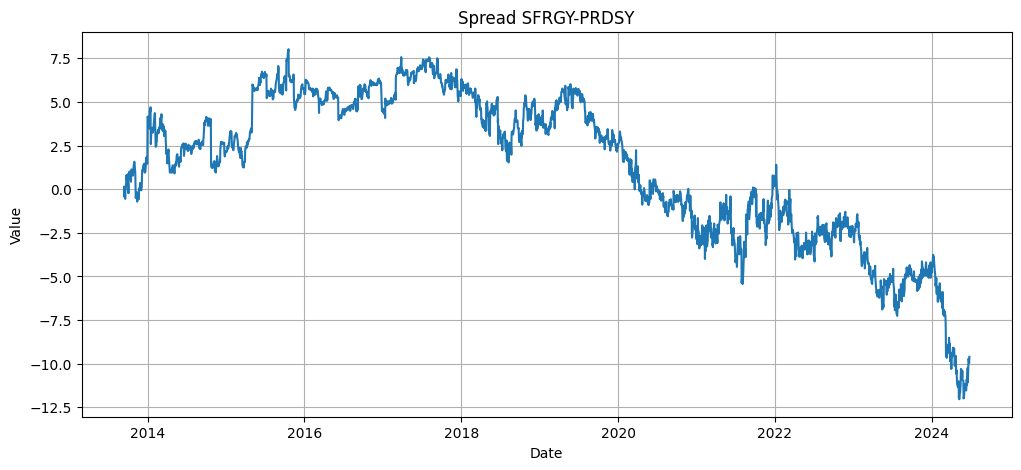

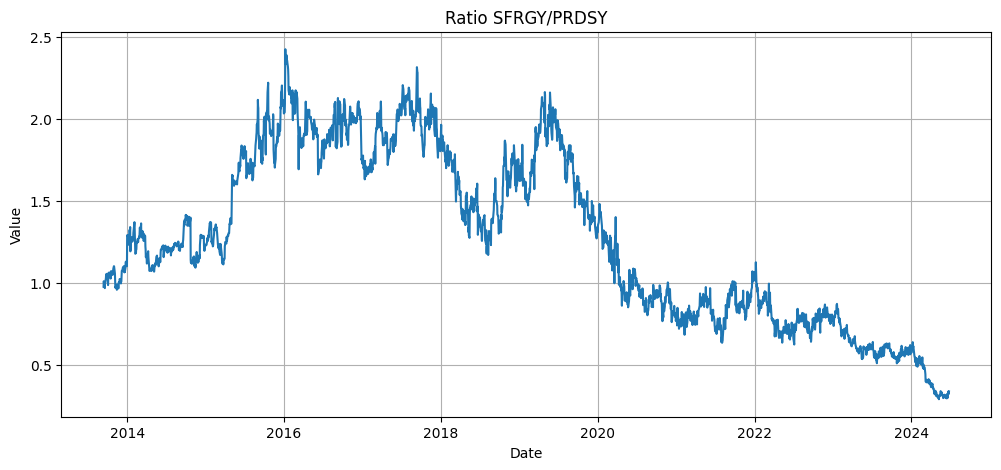

In [3]:
from_date = date(1900, 1, 1) 
to_date = date.today()
# to_date = date(2021, 9, 7) 

symbol_Long = 'SFRGY' # yfinance
symbol_Short = 'PRDSY' # yfinance

df_LONG = yf.download(symbol_Long, from_date, to_date,period="1d")
df_SHORT = yf.download(symbol_Short, from_date, to_date,period="1d")

# Remove columns except Adj Close
df_LONG = df_LONG.loc[:, "Adj Close":"Adj Close"]
df_SHORT = df_SHORT.loc[:, "Adj Close":"Adj Close"]

# Rename columns
df_LONG.rename(columns={"Adj Close":symbol_Long}, inplace=True)
df_SHORT.rename(columns={"Adj Close":symbol_Short}, inplace=True)

# Sort values in descending order, NA values at the bottom
df_LONG.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 
df_SHORT.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 

# Determine closest date - the oldest date for which there is information for both Stocks
closest_date = max(df_LONG.index[-1],df_SHORT.index[-1])
print(closest_date)
# Remove rows of data earlier than closest date
df_LONG = df_LONG.loc[df_LONG.index >= closest_date]
df_SHORT = df_SHORT.loc[df_SHORT.index >= closest_date]

# Merge dataframes now that they have the same indexes
merged_df = pd.merge(df_LONG, df_SHORT, left_index=True, right_index=True)
# Spread Trade
spread_lbl = "-".join([symbol_Long, symbol_Short])
merged_df[spread_lbl]=merged_df[symbol_Long]-merged_df[symbol_Short]
# Ratio Trade
ratio_lbl = "/".join([symbol_Long, symbol_Short])
merged_df[ratio_lbl]=merged_df[symbol_Long]/merged_df[symbol_Short]


# Plot Spread Trade
plt.figure(figsize=(12, 5))  
plt.plot(merged_df.index,merged_df[spread_lbl])
plt.title('Spread '+spread_lbl)  
plt.xlabel('Date')  
plt.ylabel('Value') 
plt.grid(True)  
plt.show() 
# Plot Ratio Trade
plt.figure(figsize=(12, 5))  
plt.plot(merged_df.index,merged_df[ratio_lbl])
plt.title('Ratio '+ratio_lbl)  
plt.xlabel('Date')  
plt.ylabel('Value') 
plt.grid(True)  
plt.show()  

### Performance Constant Equally Weighted (CEW)

In [4]:
from_date = date(1900, 1, 1) 
to_date = date.today()
# to_date = date(2021, 9, 7) 

symbol_Long = 'FRPT' #'SFRGY' # yfinance
symbol_Short = 'DLTR' #'PRDSY' # yfinance

df_LONG = yf.download(symbol_Long, from_date, to_date,period="1d")
df_SHORT = yf.download(symbol_Short, from_date, to_date,period="1d")

# Remove columns except Adj Close
df_LONG = df_LONG.loc[:, "Adj Close":"Adj Close"]
df_SHORT = df_SHORT.loc[:, "Adj Close":"Adj Close"]

# Rename columns
df_LONG.rename(columns={"Adj Close":symbol_Long}, inplace=True)
df_SHORT.rename(columns={"Adj Close":symbol_Short}, inplace=True)

# Sort values in descending order, NA values at the bottom
df_LONG.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 
df_SHORT.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 

# Determine closest date - the oldest date for which there is information for both Stocks
closest_date = max(df_LONG.index[-1],df_SHORT.index[-1])
print(closest_date)
# Remove rows of data earlier than closest date
df_LONG = df_LONG.loc[df_LONG.index >= closest_date]
df_SHORT = df_SHORT.loc[df_SHORT.index >= closest_date]

# Merge dataframes now that they have the same indexes
merged_df = pd.merge(df_LONG, df_SHORT, left_index=True, right_index=True)

# Calculate Returns
merged_df[symbol_Long+'_Ret']=(merged_df[symbol_Long]/merged_df[symbol_Long].shift(-1))-1
merged_df[symbol_Short+'_Ret']=(merged_df[symbol_Short]/merged_df[symbol_Short].shift(-1))-1


def cew(start_val,weight_long):  
    weight_short = weight_long-1    
    # Calculate CEW
    merged_df['CEW %']=merged_df[symbol_Long+'_Ret']*weight_long+merged_df[symbol_Short+'_Ret']*weight_short
    # Calculate CEW Index
    merged_df['CEW Index']=1.0
    merged_df['CEW Index'][-1]=start_val
    for i in range(-2,-1*(len(merged_df['CEW %'])+1),-1):
        merged_df['CEW Index'][i]=merged_df['CEW Index'][i+1]*(1+merged_df['CEW %'][i])
        
    plt.figure(figsize=(14, 5))
    plt.plot(merged_df.index, merged_df['CEW Index'], label='CEW Index')
    plt.title('CEW Index'+' '+symbol_Long+'&'+symbol_Short)
    plt.xlabel('Date')
    plt.ylabel('Price (CEW)')
    plt.legend()
#     plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.grid(True)


# Create index slider widgets
start_value_widget = widgets.FloatSlider(description='Start Value', 
                                disabled=False, 
                                value=100,
                                min=0,
                                step=10,
                                max=1000,       
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='d',
                                layout={'width': '50%'})  # Adjust the width of the slider                                      
weight_long_widget = widgets.FloatSlider(description='Weight Long',                                
                                value=0.5,
                                min=0,
                                max=1,                                        
                                step=0.05,
                                disabled=False,
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='.2f',
                                layout={'width': '50%'})  # Adjust the width of the slider      

cew_controls = widgets.interactive(cew, start_val=start_value_widget, weight_long= weight_long_widget)
display(cew_controls)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2014-11-07 00:00:00


interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Start Value', layout=Layo…

### Performance Non-ReBalance

In [5]:
from_date = date(1900, 1, 1) 
to_date = date.today()
# to_date = date(2021, 9, 7) 

symbol_Long = 'FRPT' #'SFRGY' # yfinance
symbol_Short = 'DLTR' #'PRDSY' # yfinance

df_LONG = yf.download(symbol_Long, from_date, to_date,period="1d")
df_SHORT = yf.download(symbol_Short, from_date, to_date,period="1d")

# Remove columns except Adj Close
df_LONG = df_LONG.loc[:, "Adj Close":"Adj Close"]
df_SHORT = df_SHORT.loc[:, "Adj Close":"Adj Close"]

# Rename columns
df_LONG.rename(columns={"Adj Close":symbol_Long}, inplace=True)
df_SHORT.rename(columns={"Adj Close":symbol_Short}, inplace=True)

# Sort values in descending order, NA values at the bottom
df_LONG.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 
df_SHORT.sort_values(by='Date', ascending=False, na_position='last',inplace=True) 

# Determine closest date - the oldest date for which there is information for both Stocks
closest_date = max(df_LONG.index[-1],df_SHORT.index[-1])
print(closest_date)
# Remove rows of data earlier than closest date
df_LONG = df_LONG.loc[df_LONG.index >= closest_date]
df_SHORT = df_SHORT.loc[df_SHORT.index >= closest_date]

# Merge dataframes now that they have the same indexes
merged_df = pd.merge(df_LONG, df_SHORT, left_index=True, right_index=True)

# Calculate Returns
merged_df[symbol_Long+'_Ret']=(merged_df[symbol_Long]/merged_df[symbol_Long].shift(-1))-1
merged_df[symbol_Short+'_Ret']=(merged_df[symbol_Short]/merged_df[symbol_Short].shift(-1))-1


def nrb(start_val_long, start_val_short):  
    # Calculate Indexes
    merged_df[symbol_Long+'Index']=1.0
    merged_df[symbol_Long+'Index'][-1]=start_val_long
    merged_df[symbol_Short+'Index']=1.0
    merged_df[symbol_Short+'Index'][-1]=start_val_short
    merged_df['NRB-Index'] = start_val_long+start_val_short
    for i in range(-2,-1*(len(merged_df[symbol_Long+'Index'])+1),-1):
        merged_df[symbol_Long+'Index'][i] = merged_df[symbol_Long+'Index'][i+1]*(1+merged_df[symbol_Long+'_Ret'][i])
        merged_df[symbol_Short+'Index'][i] = merged_df[symbol_Short+'Index'][i+1]*(1+merged_df[symbol_Short+'_Ret'][i])
        merged_df['NRB-Index'][i] = merged_df['NRB-Index'][i+1] + (merged_df[symbol_Long+'Index'][i]-merged_df[symbol_Long+'Index'][i+1]) - (merged_df[symbol_Short+'Index'][i]-merged_df[symbol_Short+'Index'][i+1])
    
    # Calculate NRB Index
    merged_df['NRB-Index_Ret'] = (merged_df['NRB-Index']/merged_df['NRB-Index'].shift(-1))-1
    # Calculate weights based on Returns
    merged_df[symbol_Long+'-Weight'] = merged_df[symbol_Long+'Index']/(merged_df[symbol_Long+'Index']+merged_df[symbol_Short+'Index'])
    merged_df[symbol_Short+'-Weight'] = merged_df[symbol_Short+'Index']/(merged_df[symbol_Long+'Index']+merged_df[symbol_Short+'Index'])
    
    # Plotting NRB Index
    plt.figure(figsize=(14, 5))
    plt.plot(merged_df.index, merged_df['NRB-Index'], label='NRB-Index')
    plt.title('NRB-Index'+' '+symbol_Long+'&'+symbol_Short)
    plt.xlabel('Date')
    plt.ylabel('Price (NRB-index)')
    plt.legend()
    plt.grid(True)


# Create index slider widgets
start_long_widget = widgets.FloatSlider(description='Start Value Long', 
                                disabled=False, 
                                value=50,
                                min=0,
                                step=10,
                                max=1000,       
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='d',
                                layout={'width': '80%'})  # Adjust the width of the slider
start_short_widget = widgets.FloatSlider(description='Start Value Short', 
                                disabled=False, 
                                value=50,
                                min=0,
                                step=10,
                                max=1000,       
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='d',
                                layout={'width': '80%'})  # Adjust the width of the slider   

nrb_controls = widgets.interactive(nrb, start_val_long=start_long_widget, start_val_short=start_short_widget)
display(nrb_controls)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2014-11-07 00:00:00


interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='Start Value Long', layout=…

In [6]:
merged_df.tail(10)

,FRPT,DLTR,FRPT_Ret,DLTR_Ret,FRPTIndex,DLTRIndex,NRB-Index,NRB-Index_Ret,FRPT-Weight,DLTR-Weight
Date,,,,,,,,,,
2014-11-20,17.590000,65.870003,-0.059358,0.051732,46.023024,53.500651,92.522373,-0.056454,0.462433,0.537567
2014-11-19,18.700001,62.630001,-0.038560,0.010324,48.927264,50.869071,98.058193,-0.024688,0.490271,0.509729
2014-11-18,19.450001,61.990002,0.013021,0.008459,50.889587,50.349253,100.540334,0.002310,0.502669,0.497331
2014-11-17,19.200001,61.470001,0.019108,-0.009507,50.235479,49.926900,100.308579,0.014371,0.501540,0.498460
2014-11-14,18.840000,62.060001,0.034596,0.001129,49.293562,50.406108,98.887455,0.016357,0.494421,0.505579
2014-11-13,18.209999,61.990002,-0.004918,0.002750,47.645208,50.349253,97.295955,-0.003825,0.486203,0.513797
2014-11-12,18.299999,61.820000,-0.011345,0.005040,47.880687,50.211175,97.669512,-0.008137,0.488121,0.511879
2014-11-11,18.510000,61.509998,0.004886,-0.005497,48.430140,49.959387,98.470754,0.005223,0.492229,0.507771
2014-11-10,18.420000,61.849998,-0.036107,0.004711,48.194661,50.235540,97.959121,-0.020409,0.489633,0.510367


## Portfolio NRB Perf

In [7]:
from_date = date(1900, 1, 1) 
to_date = date.today()
# to_date = date(2021, 9, 7) 

portfolio_NRB = pd.DataFrame()

# symbols = ['SFRGY','PRDSY','LVMUY', 'PPRUY', 'TPR', 'CPRI', 'BURBY', 'HESAY', 'CFRUY', 'MONRY', 'SWGAY']
# symbols = ['EIX','IBM','SYK','VZ','TJX','NEM','SPLK','VTRS','SYY','BDX']
symbols = ['FRPT','WMS','AGCO','TTEC','OGS','ALGT','SPLK','VTRS','SYY','BDX']

# Build Portfolio prices, find oldest common date and remove rows with no data.           
for ind,symb in enumerate(symbols):
    tmp = yf.download(symb, from_date, to_date, period="1d")    
    tmp = tmp.loc[:, "Adj Close":"Adj Close"]              # Remove columns except Adj Close    
    tmp.rename(columns={"Adj Close":symb}, inplace=True)    # Rename columns
    
    # Sort values in descending order, NA values at the bottom
    tmp.sort_values(by='Date', ascending=True, na_position='last',inplace=True) 
    
    if ind==0:
        portfolio_NRB = tmp
        continue
    
    closest_date = max(tmp.index[0],portfolio_NRB.index[0])   # Determine closest date - the oldest date for which there is information for both Stocks
    tmp = tmp.loc[tmp.index >= closest_date]                  # Remove rows of data earlier than closest date
    portfolio_NRB = portfolio_NRB.loc[portfolio_NRB.index >= closest_date]
    portfolio_NRB = portfolio_NRB.join(tmp)                   # Merge dataframes now that they have the same indexes

# Portfolio Summary by Shares and initial capital
initial_capital = 10000
portf_NRB_summary = pd.DataFrame()
portf_NRB_summary.index = symbols
portf_NRB_summary['shares']=initial_capital//portfolio_NRB.iloc[0]
portf_NRB_summary['shares'] = portf_NRB_summary['shares'].astype(int)
portf_NRB_summary['starting-GE'] = portf_NRB_summary['shares']*portfolio_NRB.iloc[0]
portf_NRB_summary['weighting'] = portf_NRB_summary['starting-GE']/sum(portf_NRB_summary['starting-GE'])
portf_NRB_summary['long/short'] = [1,1,1,1,1,1,-1,-1,-1,-1]
print(portf_NRB_summary.head(len(symbols)))

portfolio_NRB['Portfolio_Ret'] = 0
portfolio_NRB['Portfolio_Val'] = sum(portf_NRB_summary['starting-GE'])
for i,row in portfolio_NRB.iloc[1:,:len(symbols)].iterrows():
    valor = sum(portf_NRB_summary['shares']*portf_NRB_summary['long/short']*portfolio_NRB.loc[i][:len(symbols)])-sum(portf_NRB_summary['shares']*portf_NRB_summary['long/short']*portfolio_NRB.shift(1).loc[i][:len(symbols)])
    portfolio_NRB.loc[i,'Portfolio_Ret'] = valor
    portfolio_NRB.loc[i,'Portfolio_Val'] = portfolio_NRB['Portfolio_Val'].shift(1).loc[i] +portfolio_NRB.loc[i,'Portfolio_Ret']
    
portfolio_NRB.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SPLK']: Exception('%ticker%: No data found, symbol may be delisted')


C:\Users\csm116\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\csm116\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Plotting Portfolio_Val 
plt.figure(figsize=(14, 5))
plt.plot(portfolio_NRB.index, portfolio_NRB['Portfolio_Val'], label='Portfolio_Val')
plt.title('Portfolio_Val')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

## Portfolio CW Perf

In [ ]:
from_date = date(1900, 1, 1) 
to_date = date.today()
# to_date = date(2021, 9, 7) 

portfolio_CW = pd.DataFrame()

# symbols = ['SFRGY','PRDSY','LVMUY', 'PPRUY', 'TPR', 'CPRI', 'BURBY', 'HESAY', 'CFRUY', 'MONRY', 'SWGAY']
# symbols = ['EIX','IBM','SYK','VZ','TJX','NEM','SPLK','VTRS','SYY','BDX']
symbols = ['FRPT','WMS','AGCO','TTEC','OGS','ALGT','SPLK','VTRS','SYY','BDX']

# Build Portfolio prices, find oldest common date and remove rows with no data.           
for ind,symb in enumerate(symbols):
    tmp = yf.download(symb, from_date, to_date, period="1d")    
    tmp = tmp.loc[:, "Adj Close":"Adj Close"]              # Remove columns except Adj Close    
    tmp.rename(columns={"Adj Close":symb}, inplace=True)    # Rename columns
    
    # Sort values in descending order, NA values at the bottom
    tmp.sort_values(by='Date', ascending=True, na_position='last',inplace=True) 
    
    if ind==0:
        portfolio_CW = tmp
        continue
    
    closest_date = max(tmp.index[0],portfolio_CW.index[0])   # Determine closest date - the oldest date for which there is information for both Stocks
    tmp = tmp.loc[tmp.index >= closest_date]                  # Remove rows of data earlier than closest date
    portfolio_CW = portfolio_CW.loc[portfolio_CW.index >= closest_date]
    portfolio_CW = portfolio_CW.join(tmp)                   # Merge dataframes now that they have the same indexes

# Portfolio Summary by Shares and initial capital
initial_capital = 10000
portf_CW_summary = pd.DataFrame()
portf_CW_summary.index = symbols
portf_CW_summary['Gross Weight'] = [10,10,10,10,10,10,10,10,10,10]
portf_CW_summary['Gross Weight'] = portf_CW_summary['Gross Weight']/100
portf_CW_summary['long/short'] = [1,1,1,1,1,1,-1,-1,-1,-1]
print(portf_CW_summary.head(len(symbols)))


for col in portfolio_CW.columns:
    portfolio_CW[col] = (portfolio_CW[col]/portfolio_CW[col].shift(1))-1

initial_capital = 100000
portfolio_CW['Portfolio_Ret'] = 0
portfolio_CW['Portfolio_Index'] = initial_capital
for i,row in portfolio_CW.iloc[1:,:len(symbols)].iterrows():
    portfolio_CW.loc[i,'Portfolio_Ret'] = sum(portf_CW_summary['Gross Weight']*portf_CW_summary['long/short']*portfolio_CW.loc[i][:len(symbols)])
    portfolio_CW.loc[i,'Portfolio_Index'] = portfolio_CW.shift(1).loc[i,'Portfolio_Index']*(1+portfolio_CW.loc[i,'Portfolio_Ret'])
    
portfolio_CW.head()

In [ ]:
# Plotting Portfolio_Val 
plt.figure(figsize=(14, 5))
plt.plot(portfolio_CW.index, portfolio_CW['Portfolio_Index'], label='Portfolio_Index')
plt.title('Portfolio_Index')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)